# Shifted regions

**Goal:** Do the validation study on the shifted regions samples.

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
from glob import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib import gridspec

from scipy.optimize import curve_fit

import os

os.sys.path += ['../non-resonant-studies/','../gp-for-flows/','../PyATLASstyle/','../../hh4b/hh4b-plots/'] 

from utils import f, f_2comp

from statUtils import getEigenvariations

from gp import *
from flows import *
from bkgPred import *

from hh4b_plots.phys_utils import get_lumi

import hist

# Let's do ATLAS style plots too!
import matplotlib as mpl
import PyATLASstyle as pas
pas.applyATLASstyle(mpl)


%load_ext autoreload
%autoreload 2

Using uproot4


In [40]:
SR_xs = [70,170,170,78]
SR_ys = [66,68,160,166]

colors = ['C0', 'C1', 'C2', 'C3']

eps = 0.05
r_CR = 45

labels = {(x,y):l for x,y,l in zip(SR_xs,SR_ys,['lower left','lower right','upper right','upper left'])}

### Load in the QCD pred histograms

In [3]:
c = 'val1p1'

fc = f'../gp-for-flows/configs/{c}.json'
with open(fc,'r') as cfile:
    hps = json.load(cfile)

L,H,nb,K,lr,beta,p = hps['L'],hps['H'],hps['nb'],hps['K'],hps['lr'],hps['beta'],hps['p']
colTag = '_'.join(hps['cols'])

modelConfig = f'nsf_rq-coupling_{colTag}_lu_{L}_layers_H_{H}_{nb}_blocks_K_{K}_B_3_lr_{lr}_{beta}_p{p}_iter0'

nSeeds = 25

yrs = ['16','17','18']

In [21]:
hdict = {(x,y): {yr:{} for yr in yrs} for x,y in zip(SR_xs,SR_ys)} # GP + flow prediction
hAll = {(x,y): {} for x,y in zip(SR_xs,SR_ys)}

for x,y in zip(SR_xs,SR_ys):
    
    i = (x,y)
    
    subDir = f'qcd161718-MAY21_4b_sr_{x}.0_{y}.0_detaCut_ggf'
    modelDir = f'../gp-for-flows/models/{subDir}'

    for yr in yrs:
        with open(f'{modelDir}/{modelConfig}/hists_gp_100k_{yr}.json','r') as hfile:
            out = json.load(hfile)

        for k in out.keys():
            hdict[i][yr][k] = np.array( out[k])
            
            
    for k in hdict[i]['16'].keys():
        if 'std' in k: 
            continue

        hAll[i][k] = np.vstack([hd[k] for yr,hd in hdict[i].items()]).sum(axis=0)
    
    
    for c, tag in product(myVars+['X_hh_dEta_hh_m_hh'],['','_Xwt_cut']):
    
        k = f'{c}_SR{tag}'

        # Correlated errors
        stack = np.vstack([hAll[i][f'{k}_{j}'] for j in range(nSeeds)])
        hAll[i][f"{k}_std"] = np.sqrt(np.sum((stack - hAll[i][f'{k}_mean'])**2, axis=0) / (nSeeds-1))

### Load in the dfs for obs + $t\bar{t}$ templates

In [5]:
tree='fullmassplane'
load_mask = 'ntag >= 4 & ~pass_vbf_sel & m_h1 > 50 & m_h2 > 40'

In [9]:
fnames = [f'../data/RR/cryptotuples/data{yr}.root' for yr in yrs]

hc_vars = [f'{v}_h{i}' for v, i in product(['pT','eta','phi'],[1,2])]

load_cols = ['ntag','X_wt_tag','pass_vbf_sel','m_h1','m_h2','event_number',"passMuonIso"]
load_cols = load_cols + d_cols+hc_vars

In [10]:
myRanges,edg_3d = get_default_bins()

In [11]:
dfs = []

for fname in fnames:
    print(fname)
    with uproot.open(fname) as fi:
        
        dfi = fi[tree].arrays(load_cols,library='pd')
        mi = dfi.eval(load_mask)


        dfs.append( dfi[mi] )
        
dat = pd.concat(dfs).reset_index()

../data/RR/cryptotuples/data16.root
../data/RR/cryptotuples/data17.root
../data/RR/cryptotuples/data18.root


In [12]:
ahnames = [f'../data/RR/cryptotuples/ttbar/quads/MC/410471_mc16{yr_to_mc[yr]}/NanoNTuple.root' for yr in yrs]
slnames = [f'../data/RR/cryptotuples/ttbar/quads/MC/410470_mc16{yr_to_mc[yr]}/NanoNTuple.root' for yr in yrs]

In [13]:
dfs = []

for yr,fname in zip(yrs,ahnames):
    print(fname)
    with uproot.open(fname) as fi:
        
        dfi = fi[tree].arrays(load_cols+['mc_sf'],library='pd')
        mi = dfi.eval(load_mask)

        dfi['mc_sf'] *= lumi[yr]
        
        dfs.append( dfi[mi] )
        
ah = pd.concat(dfs).reset_index()

../data/RR/cryptotuples/ttbar/quads/MC/410471_mc16a/NanoNTuple.root
../data/RR/cryptotuples/ttbar/quads/MC/410471_mc16d/NanoNTuple.root
../data/RR/cryptotuples/ttbar/quads/MC/410471_mc16e/NanoNTuple.root


In [14]:
dfs = []

for yr,fname in zip(yrs,slnames):
    print(fname)
    with uproot.open(fname) as fi:
        
        dfi = fi[tree].arrays(load_cols+['mc_sf'],library='pd')
        mi = dfi.eval(load_mask)

        dfi['mc_sf'] *= lumi[yr]
            
        dfs.append( dfi[mi] )
        
sl = pd.concat(dfs).reset_index()

../data/RR/cryptotuples/ttbar/quads/MC/410470_mc16a/NanoNTuple.root
../data/RR/cryptotuples/ttbar/quads/MC/410470_mc16d/NanoNTuple.root
../data/RR/cryptotuples/ttbar/quads/MC/410470_mc16e/NanoNTuple.root


In [49]:
labels

{(70, 66): 'lower left',
 (170, 68): 'lower right',
 (170, 160): 'upper right',
 (78, 166): 'upper left'}

In [16]:
mask_str = f'X_wt_tag > 1.5 & kinematic_region == 0'

In [55]:
fig,axes = plt.subplots(2,2,figsize=(8,8))

for x,y,i,j in zip(SR_xs,SR_ys,[1,1,0,0],[0,1,1,0]):
        
    # Reset the kinematic regions for the dfs
    get_kinematic_regions(sl, x, y, eps, r_CR)

    m_sl = sl.eval(mask_str)
    axes[i,j].hist2d(sl.loc[m_sl,'m_h1'],sl.loc[m_sl,'m_h2'],[25,25],[[20,200],[20,200]],
               cmap='Blues',weights=sl.loc[m_sl,'mc_sf'])
plt.show()

Using 0.17714285714285716 m_h1 resolution.
Using 0.17727272727272728 m_h2 resolution.
Using 0.07294117647058823 m_h1 resolution.
Using 0.1720588235294118 m_h2 resolution.
Using 0.07294117647058823 m_h1 resolution.
Using 0.07312500000000001 m_h2 resolution.
Using 0.158974358974359 m_h1 resolution.
Using 0.07048192771084338 m_h2 resolution.


Using 0.17714285714285716 m_h1 resolution.
Using 0.17727272727272728 m_h2 resolution.
Using 0.07294117647058823 m_h1 resolution.
Using 0.1720588235294118 m_h2 resolution.
Using 0.07294117647058823 m_h1 resolution.
Using 0.07312500000000001 m_h2 resolution.
Using 0.158974358974359 m_h1 resolution.
Using 0.07048192771084338 m_h2 resolution.


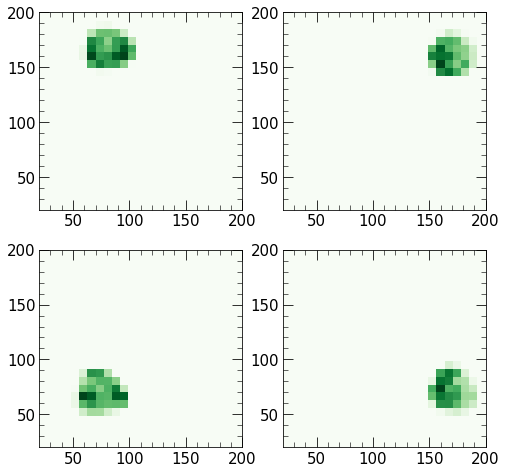

In [54]:
fig,axes = plt.subplots(2,2,figsize=(8,8))

for x,y,i,j in zip(SR_xs,SR_ys,[1,1,0,0],[0,1,1,0]):
        
    # Reset the kinematic regions for the dfs
    get_kinematic_regions(ah, x, y, eps, r_CR)

    m_ah = ah.eval(mask_str)
    axes[i,j].hist2d(ah.loc[m_ah,'m_h1'],ah.loc[m_ah,'m_h2'],[25,25],[[20,200],[20,200]],
               cmap='Greens',weights=ah.loc[m_ah,'mc_sf'])
plt.show()

## What does this look like out-of-the box?

Using 0.17714285714285716 m_h1 resolution.
Using 0.17727272727272728 m_h2 resolution.
Using 0.17714285714285716 m_h1 resolution.
Using 0.17727272727272728 m_h2 resolution.
Using 0.17714285714285716 m_h1 resolution.
Using 0.17727272727272728 m_h2 resolution.


Using 0.07294117647058823 m_h1 resolution.
Using 0.1720588235294118 m_h2 resolution.
Using 0.07294117647058823 m_h1 resolution.
Using 0.1720588235294118 m_h2 resolution.
Using 0.07294117647058823 m_h1 resolution.
Using 0.1720588235294118 m_h2 resolution.


Using 0.07294117647058823 m_h1 resolution.
Using 0.07312500000000001 m_h2 resolution.
Using 0.07294117647058823 m_h1 resolution.
Using 0.07312500000000001 m_h2 resolution.
Using 0.07294117647058823 m_h1 resolution.
Using 0.07312500000000001 m_h2 resolution.


<ipython-input-62-1c0c6854a89f>:54: RuntimeWarning: invalid value encountered in true_divide
  ax2.fill_between(range(len(nom)),1+err/h_prev,1-err/h_prev,
<ipython-input-62-1c0c6854a89f>:71: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(range(len(nom)), h_3d/h_prev, np.sqrt(h_3d)/h_prev,


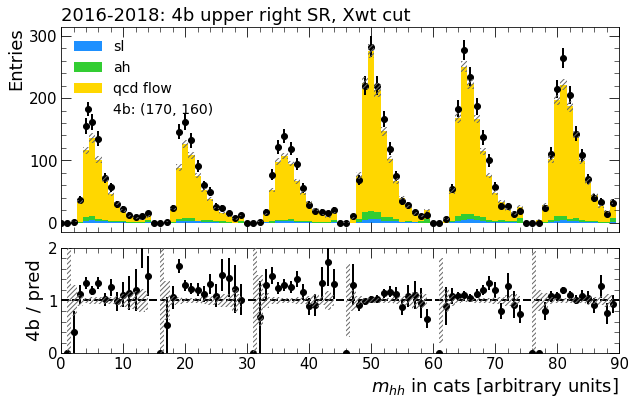

Using 0.158974358974359 m_h1 resolution.
Using 0.07048192771084338 m_h2 resolution.
Using 0.158974358974359 m_h1 resolution.
Using 0.07048192771084338 m_h2 resolution.
Using 0.158974358974359 m_h1 resolution.
Using 0.07048192771084338 m_h2 resolution.


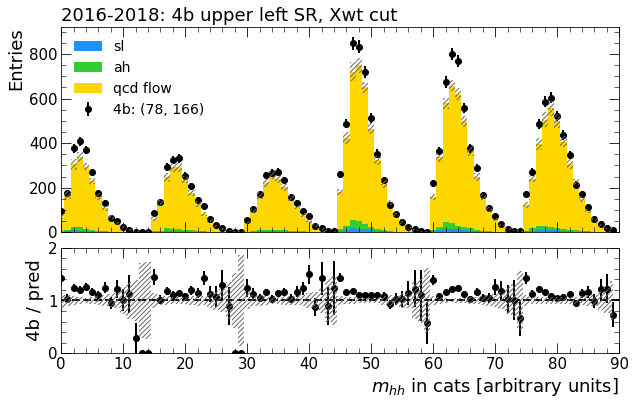

In [62]:
for x,y in zip(SR_xs,SR_ys):
    
    i = (x,y)
    k = '_SR_Xwt_cut'
    fig, (ax1,ax2) = plt.subplots(figsize=(10,6),nrows=2,sharex=True,
                                  gridspec_kw={"height_ratios":[.66,.34],
                                               "hspace":0.1})
    # Reset the kinematic regions for the dfs
    for dfi in [dat,ah,sl]:
        get_kinematic_regions(dfi, x, y, eps, r_CR)
        
    # ttbar templates
    m_ah = ah.eval(mask_str)
    h_3d_ah = np.histogramdd(ah.loc[m_ah,d_cols].values,
                             edg_3d,
                             weights=ah.loc[m_ah,'mc_sf'].values)[0].flatten()
    dh_3d_ah = np.sqrt(
                    np.histogramdd(
                        ah.loc[m_ah,d_cols].values,
                        edg_3d,
                        weights=ah.loc[m_ah,'mc_sf'].values**2)[0].flatten())

    m_sl = sl.eval(mask_str)
    h_3d_sl = np.histogramdd(sl.loc[m_sl,d_cols].values,
                             edg_3d,
                             weights=sl.loc[m_sl,'mc_sf'].values)[0].flatten()
    dh_3d_sl = np.sqrt(
                    np.histogramdd(
                        sl.loc[m_sl,d_cols].values,
                        edg_3d,
                        weights=sl.loc[m_sl,'mc_sf'].values**2)[0].flatten())

    nom = hAll[i][f'X_hh_dEta_hh_m_hh{k}_mean']
    std = hAll[i][f'X_hh_dEta_hh_m_hh{k}_std']

    h_prev = 0
    for hi, ci, li in zip([h_3d_sl,h_3d_ah,nom],
                          ['dodgerblue','limegreen','gold'],
                          ['sl','ah','qcd flow']):

        ax1.hist(range(len(nom)),np.arange(-.5,len(nom)+.5,1),
                 weights=hi,bottom=h_prev,color=ci,label=li)
        h_prev+=hi


    '''
    Overlay model err
    '''
    err = np.sqrt(std**2+dh_3d_ah**2+dh_3d_sl**2)

    ax1.fill_between(range(len(nom)),h_prev+err,h_prev-err,
                     fc="None",edgecolor='dimgrey', hatch='/////',
                     zorder=6,lw=0,step='mid')
    ax2.fill_between(range(len(nom)),1+err/h_prev,1-err/h_prev,
                     fc="None",edgecolor='dimgrey', hatch='/////',
                     zorder=6,lw=0,step='mid')

    ax2.plot([0,len(nom)], [1]*2,lw=2,color='k',ls='--')
    '''
    Obs data
    '''
    mask = dat.eval(mask_str)

    h_3d = np.histogramdd(dat.loc[mask,d_cols].values,edg_3d)[0].flatten()

    ax1.errorbar(range(len(nom)), h_3d, 
                 np.sqrt(h_3d), 
                 lw=0, elinewidth=2,marker='o',color='k',
                 label=f'4b: {i}')

    ax2.errorbar(range(len(nom)), h_3d/h_prev, np.sqrt(h_3d)/h_prev, 
                 lw=0, elinewidth=2,marker='o',color='k')

    ax2.set_xlabel('$m_{hh}$ in cats [arbitrary units]',x=1,ha='right',fontsize=18)
    ax1.set_ylabel('Entries',y=1,ha='right',fontsize=18)
    ax1.set_title(f'2016-2018: 4b {labels[i]} SR, Xwt cut',x=0,loc='left')

    ax2.set_ylabel('4b / pred',fontsize=18)
    
    ax1.legend()
    ax1.set_xlim(0,90)
    ax2.set_ylim(0,2)
    #plt.savefig(f'figures/qcd161718-MAY21_4b_sr_{x}_{y}_detaCut_ggf/m_hh_cats_prefit.pdf',bbox_inches='tight')
    plt.show()
    #break

Using 0.17714285714285716 m_h1 resolution.
Using 0.17727272727272728 m_h2 resolution.
Using 0.17714285714285716 m_h1 resolution.
Using 0.17727272727272728 m_h2 resolution.
Using 0.17714285714285716 m_h1 resolution.
Using 0.17727272727272728 m_h2 resolution.


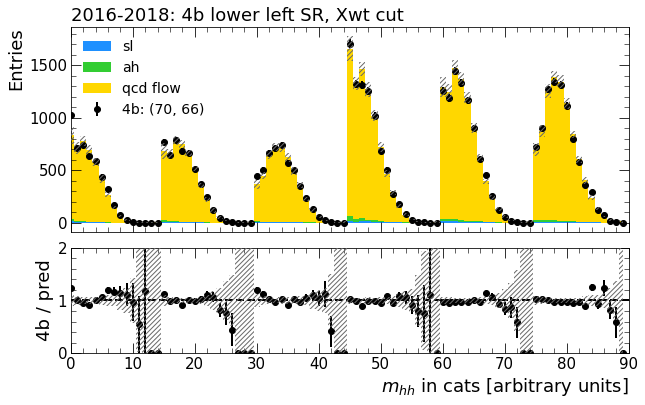

Using 0.07294117647058823 m_h1 resolution.
Using 0.1720588235294118 m_h2 resolution.
Using 0.07294117647058823 m_h1 resolution.
Using 0.1720588235294118 m_h2 resolution.
Using 0.07294117647058823 m_h1 resolution.
Using 0.1720588235294118 m_h2 resolution.


Using 0.07294117647058823 m_h1 resolution.
Using 0.07312500000000001 m_h2 resolution.
Using 0.07294117647058823 m_h1 resolution.
Using 0.07312500000000001 m_h2 resolution.
Using 0.07294117647058823 m_h1 resolution.
Using 0.07312500000000001 m_h2 resolution.


<ipython-input-63-aa0421bb3c2b>:67: RuntimeWarning: invalid value encountered in true_divide
  ax2.fill_between(range(len(nom)),1+err/h_prev,1-err/h_prev,
<ipython-input-63-aa0421bb3c2b>:81: RuntimeWarning: invalid value encountered in true_divide
  ax2.errorbar(range(len(nom)), h_3d/h_prev, np.sqrt(h_3d)/h_prev,


Using 0.158974358974359 m_h1 resolution.
Using 0.07048192771084338 m_h2 resolution.
Using 0.158974358974359 m_h1 resolution.
Using 0.07048192771084338 m_h2 resolution.
Using 0.158974358974359 m_h1 resolution.
Using 0.07048192771084338 m_h2 resolution.


In [63]:
for x,y in zip(SR_xs,SR_ys):
    
    i = (x,y)
    k = '_SR_Xwt_cut'
    fig, (ax1,ax2) = plt.subplots(figsize=(10,6),nrows=2,sharex=True,
                                  gridspec_kw={"height_ratios":[.66,.34],
                                               "hspace":0.1})
    # Reset the kinematic regions for the dfs
    for dfi in [dat,ah,sl]:
        get_kinematic_regions(dfi, x, y, eps, r_CR)
        
    # ttbar templates
    m_ah = ah.eval(mask_str)
    h_3d_ah = np.histogramdd(ah.loc[m_ah,d_cols].values,
                             edg_3d,
                             weights=ah.loc[m_ah,'mc_sf'].values)[0].flatten()
    dh_3d_ah = np.sqrt(
                    np.histogramdd(
                        ah.loc[m_ah,d_cols].values,
                        edg_3d,
                        weights=ah.loc[m_ah,'mc_sf'].values**2)[0].flatten())

    m_sl = sl.eval(mask_str)
    h_3d_sl = np.histogramdd(sl.loc[m_sl,d_cols].values,
                             edg_3d,
                             weights=sl.loc[m_sl,'mc_sf'].values)[0].flatten()
    dh_3d_sl = np.sqrt(
                    np.histogramdd(
                        sl.loc[m_sl,d_cols].values,
                        edg_3d,
                        weights=sl.loc[m_sl,'mc_sf'].values**2)[0].flatten())

    nom = hAll[i][f'X_hh_dEta_hh_m_hh{k}_mean']
    std = hAll[i][f'X_hh_dEta_hh_m_hh{k}_std']

    '''
    Norm to the obs datat
    '''
    
    mask = dat.eval(mask_str)
    h_3d = np.histogramdd(dat.loc[mask,d_cols].values,edg_3d)[0].flatten()

    
    bkg = h_3d_sl + h_3d_ah + nom
    norm = np.sum(h_3d) / np.sum(bkg)
    
    
    h_prev = 0
    for hi, ci, li in zip([h_3d_sl,h_3d_ah,nom],
                          ['dodgerblue','limegreen','gold'],
                          ['sl','ah','qcd flow']):

        ax1.hist(range(len(nom)),np.arange(-.5,len(nom)+.5,1),
                 weights=hi*norm,bottom=h_prev,color=ci,label=li)
        h_prev += hi*norm


    '''
    Overlay model err
    '''
    err = np.sqrt(std**2+dh_3d_ah**2+dh_3d_sl**2)
    err *= norm
    
    ax1.fill_between(range(len(nom)),h_prev+err,h_prev-err,
                     fc="None",edgecolor='dimgrey', hatch='/////',
                     zorder=6,lw=0,step='mid')
    ax2.fill_between(range(len(nom)),1+err/h_prev,1-err/h_prev,
                     fc="None",edgecolor='dimgrey', hatch='/////',
                     zorder=6,lw=0,step='mid')

    ax2.plot([0,len(nom)], [1]*2,lw=2,color='k',ls='--')
    
    '''
    Obs data
    '''
    ax1.errorbar(range(len(nom)), h_3d, 
                 np.sqrt(h_3d), 
                 lw=0, elinewidth=2,marker='o',color='k',
                 label=f'4b: {i}')

    ax2.errorbar(range(len(nom)), h_3d/h_prev, np.sqrt(h_3d)/h_prev, 
                 lw=0, elinewidth=2,marker='o',color='k')

    ax2.set_xlabel('$m_{hh}$ in cats [arbitrary units]',x=1,ha='right',fontsize=18)
    ax1.set_ylabel('Entries',y=1,ha='right',fontsize=18)
    ax1.set_title(f'2016-2018: 4b {labels[i]} SR, Xwt cut',x=0,loc='left')

    ax2.set_ylabel('4b / pred',fontsize=18)
    
    ax1.legend()
    ax1.set_xlim(0,90)
    ax2.set_ylim(0,2)
    #plt.savefig(f'figures/qcd161718-MAY21_4b_sr_{x}_{y}_detaCut_ggf/m_hh_cats_prefit.pdf',bbox_inches='tight')
    plt.show()
    #break

### Compare the inclusively trained flow + pure QCD

In [43]:
# for x,y in zip(SR_xs,SR_ys):
#     i = (x,y)
#     k = '_SR_Xwt_cut'
#     fig, (ax1,ax2,ax3) = plt.subplots(figsize=(10,8),nrows=3,sharex=True,
#                                       gridspec_kw={"height_ratios": 
#                                                    [.5,.25,.25],
#                                                    "hspace":0.1})
#     # Reset the kinematic regions for the dfs
#     for dfi in [dat,ah,sl]:
#         get_kinematic_regions(dfi, x, y, eps, r_CR)
#     # ttbar templates
#     m_ah = ah.eval(mask_str)
#     h_3d_ah = np.histogramdd(ah.loc[m_ah,d_cols].values,
#                              edg_3d,
#                              weights=ah.loc[m_ah,'mc_sf'].values)[0].flatten()
#     dh_3d_ah = np.sqrt(
#                     np.histogramdd(
#                         ah.loc[m_ah,d_cols].values,
#                         edg_3d,
#                         weights=ah.loc[m_ah,'mc_sf'].values**2)[0].flatten())

#     m_sl = sl.eval(mask_str)
#     h_3d_sl = np.histogramdd(sl.loc[m_sl,d_cols].values,
#                              edg_3d,
#                              weights=sl.loc[m_sl,'mc_sf'].values)[0].flatten()
#     dh_3d_sl = np.sqrt(
#                     np.histogramdd(
#                         sl.loc[m_sl,d_cols].values,
#                         edg_3d,
#                         weights=sl.loc[m_sl,'mc_sf'].values**2)[0].flatten())

#     nom = hAll[i][f'X_hh_dEta_hh_m_hh{k}_mean']
#     std = hAll[i][f'X_hh_dEta_hh_m_hh{k}_std']

#     h_prev = 0
#     for hi, ci, li in zip([h_3d_sl,h_3d_ah,nom],
#                           ['dodgerblue','limegreen','gold'],
#                           ['sl','ah','qcd flow']):

#         ax1.hist(range(len(nom)),np.arange(-.5,len(nom)+.5,1),
#                  weights=hi,bottom=h_prev,color=ci,label=li)
#         h_prev+=hi


#     '''
#     Overlay model err
#     '''
#     err = np.sqrt(std**2+dh_3d_ah**2+dh_3d_sl**2)

#     ax1.fill_between(range(len(nom)),h_prev+err,h_prev-err,
#                      fc="None",edgecolor='dimgrey', hatch='/////',
#                      zorder=6,lw=0,step='mid')
#     ax3.fill_between(range(len(nom)),1+err/h_prev,1-err/h_prev,
#                      fc="None",edgecolor='dimgrey', hatch='/////',
#                      zorder=6,lw=0,step='mid')

#     ax3.plot([0,len(nom)], [1]*2,lw=2,color='k',ls='--')

#     '''
#     Inclusively trained flow
#     '''
# #     nom = iAll[i][f'X_hh_dEta_hh_m_hh{k}_mean']
# #     std = iAll[i][f'X_hh_dEta_hh_m_hh{k}_std']
# #     c = colors[i]

# #     ax1.plot(nom,color=c,label=f'incl flow',lw=3)   

# #     ax1.fill_between(range(len(nom)),nom+std,nom-std,color=c,alpha=0.3)
# #     ax2.fill_between(range(len(nom)),1+std/nom,1-std/nom,
# #                  color=c,alpha=0.3)

#     #ax2.plot([0,len(nom)], [1]*2,lw=2,color=c)

#     '''
#     Obs data
#     '''
#     mask = dat.eval(mask_str)

#     h_3d = np.histogramdd(dat.loc[mask,d_cols].values,edg_3d)[0].flatten()

#     ax1.errorbar(range(len(nom)), h_3d, 
#                  np.sqrt(h_3d), 
#                  lw=0, elinewidth=2,marker='o',color='k',
#                  label=f'3b1f: replica {i}')

# #     ax2.errorbar(range(len(nom)), h_3d/nom, np.sqrt(h_3d)/nom, 
# #                  lw=0, elinewidth=2,marker='o',color='k')
#     ax3.errorbar(range(len(nom)), h_3d/h_prev, np.sqrt(h_3d)/h_prev, 
#                  lw=0, elinewidth=2,marker='o',color='k')

#     ax3.set_xlabel('$m_{hh}$ in cats [arbitrary units]',x=1,ha='right',fontsize=18)
#     ax1.set_ylabel('Entries',y=1,ha='right',fontsize=18)
#     ax1.set_title(f'2016-2018: 4b SR ({x},{y}) [{labels[i]}], Xwt cut',x=0,loc='left')

#     ax2.set_ylabel('4b / incl',fontsize=18)
#     ax3.set_ylabel('4b / pred',fontsize=18)

#     ax1.legend()
#     ax1.set_xlim(0,90)
#     ax2.set_ylim(0.5,1.5)
#     ax3.set_ylim(0.5,1.5)

#     #plt.savefig(f'figures/qcd161718-MAY21_4b_sr_{x}_{y}_detaCut_ggf/m_hh_cats_prefit_cf_incl.pdf',bbox_inches='tight')
#     plt.show()
#     #break

In [39]:
labels

['sl', 'ah', 'qcd flow', '3b1f: replica (70, 66)']

In [31]:
 hAll[i][f'X_hh_dEta_hh_m_hh{k}_mean']

array([ 62.8754192 , 159.29430159, 280.78931179, 315.16318814,
       280.07748114, 219.16985148, 154.55290201, 102.97425742,
        66.97751244,  39.91429368,  21.33192537,   8.60767401,
         3.11606048,   1.26135165,   1.34907328,  55.05945342,
       125.49034488, 229.83515322, 274.93672286, 276.08271687,
       225.45112799, 167.23260106, 122.06380885,  78.54301447,
        50.03007651,  28.37316281,  13.49590837,   5.98771006,
         2.41191382,   2.15019395,  41.76099376,  86.8074652 ,
       156.83403743, 210.96912893, 247.64074935, 226.66350963,
       193.3157478 , 147.99031543, 107.18317414,  74.24887458,
        47.23663687,  27.71695436,  13.77080966,   6.6850477 ,
         4.8545065 , 167.35365036, 394.28239496, 665.85080385,
       698.44218393, 614.51580263, 444.01489101, 308.19006822,
       204.58372712, 126.82638435,  76.52552124,  41.24561129,
        21.01868348,   9.49170832,   4.42814112,   3.34854652,
       147.50241866, 312.67857716, 534.59650861, 618.83

### The normalized versions

While I'm at it, let's set up a table for the normalizations.